In [2]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import math
from matplotlib.animation import FuncAnimation
from lmfit import minimize, fit_report, Parameters
from aim2_population_model_spatial_aff_parallel import get_mod_spike
from model_constants import (MC_GROUPS, LifConstants)
from popul_model import pop_model
from aim2_population_model_spatial_aff_parallel import Afferent, SimulationConfig, Simulation

In [3]:
#Global Variables
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False)
lmpars.add('tau2', value=200, vary=False)
lmpars.add('tau3', value=1744.6, vary=False)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars


# lmpars_init_dict = {}
# lmpars = Parameters()
# lmpars.add('tau1', value=8, vary=False)
# lmpars.add('tau2', value=200, vary=False)
# lmpars.add('tau3', value=1744.6, vary=False)
# lmpars.add('tau4', value=np.inf, vary=False)
# lmpars.add('k1', value=.74, vary=False, min=0) #a constant
# lmpars.add('k2', value=5.5, vary=False, min=0) #b constant
# lmpars.add('k3', value=.025, vary=False, min=0) #c constant
# lmpars.add('k4', value=.075, vary=False, min=0)
# lmpars_init_dict['t3f12v3final'] = lmpars



In [4]:
#random helper functino calculating the distance between 2 points
def distance(x1,y1,x2,y2):
    x = (x2-x1) **2
    y  = (y2 -y1) **2
    return np.sqrt(x+y)


#find the non matches in 2 lists
def find_non_matches(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    
    # Find elements unique to each list
    non_matches = list(set1.symmetric_difference(set2))
    
    return non_matches


**Population Model Class**

In [27]:
class VF_Population_Model:
    
    def __init__(self, vf_tip_size, aff_type):
        self.vf_tip_size = vf_tip_size
        self.aff_type = aff_type
        self.results = None
        self.stress_data = None
        self.x_coords = None
        self.y_coords = None
        self.time_of_firing = None
    """
        functino takes in a vf_tip_size (given that that there is data assicated with it) an
        afferent type, and runs the single unit model for all of those coordinates with the data

        firing time: takes either pike or a certain time, during thd ramp phase when the 
        
    """
    def spatial_stress_vf_model(self, scaling_factor =1.0, time_of_firing = "peak"):
        self.time_of_firing = time_of_firing
        #reading data in 
        # coords = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_coords.csv", header = None)

        #reading in Anikas new coords 

        coords = pd.read_csv(f"data/anika_new_data/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr.csv")

        #assinging the instance variables for all the x coords and y coords of spatial points
        self.x_coords = [float(row[0]) for row in coords.iloc[0:].values]
        self.y_coords = [float(row[1]) for row in coords.iloc[0:].values]
        # stress_data = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_stress.csv" )
        


        stress_data = pd.read_csv(f"data/anika_new_data/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr.csv")
        time = stress_data['Time (ms)'].to_numpy()

        afferent_type = []
        x_pos = []
        y_pos = []
        spikes = []
        mean_firing_frequency = []
        peak_firing_frequency = []
        first_spike_time = []
        last_spike_time = []
        stress_trace = []
        entire_iff = []

        #iterating through each of the coordinates
        for i, row in coords.iloc[0:].iterrows():
            i+=1 #incrementing so index starts from first index
            # print(f"index: {i}, row: {row}")
            #getting stress data
            
            if f"Coord {i} Stress (kPa)" in stress_data.columns:
                stress = stress_data[f"Coord {i} Stress (kPa)"] * scaling_factor
                print(f"RECIEVING STRESS DATA AT COORD {i} at x:{row.iloc[0]}and y:{row.iloc[1]} MEAN STRESS IS {np.mean(stress)}")
            else:
                logging.warning("STRESS VALUE COULD NOT BE INDEXED")

            lmpars = lmpars_init_dict['t3f12v3final']
            if self.aff_type == "RA":
                lmpars['tau1'].value = 2.5
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress)

            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                logging.warning(f"SPIKES COULD NOT BE GENERATED FOR COORD {i} and X: {row.iloc[0]} and Y:{row.iloc[1]}, BECAUSE STRESS WAS TOO LOW")
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time,mod_fr_inst_interp)
    
            #appending stuff to lists
            afferent_type.append(self.aff_type)
            x_pos.append(row.iloc[0])
            y_pos.append(row.iloc[1])
            spikes.append(len(mod_spike_time) if len(mod_spike_time) !=0 else None)
            mean_firing_frequency.append(features["Average Firing Rate"])
            if time_of_firing == "peak":
                peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            else:
                #firing frequency at a specific time , finds the closest iff value to the specified time 
                # Find the index of the mod_spike_time closest to time_of_firing
                closest_spike_idx = np.argmin(np.abs(np.array(mod_spike_time) - time_of_firing))
                # Get the corresponding mod_fr_inst_interp value tied to this spike time
                temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                # Append the instantaneous firing frequency at the closest spike time
                peak_firing_frequency.append(temp_fr_inst_interp)
        
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != None else None)
            last_spike_time.append(mod_spike_time[-1])
            stress_trace.append(stress)
            entire_iff.append(mod_fr_inst_interp)
            
            
            
        model_results = {
            'afferent_type': self.aff_type,
            'x_position': x_pos,
            'y_position': y_pos,
            'num_of_spikes' : spikes,
            'mean_firing_frequency' : mean_firing_frequency,
            'peak_firing_frequency' : peak_firing_frequency, 
            'first_spike_time': first_spike_time,
            'last_spike_time' : last_spike_time,
            'each_coord_stress': stress_trace, 
            'entire_iff': entire_iff
        }

        self.results = model_results
        return model_results

    def radial_stress_vf_model(self,scaling_factor = 0.3):
        """ Read in the Radial which has sample stress traces for every 2mm from a center point
        to calculate firing"""

        #regex pattern for exstracting the distance from the middle point
        distance_regex = r'\d\.\d{2}'

        #reading data from spatial stress data file for 50 (or n) data points in a grid
        coords = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_coords.csv", header = None)

        self.x_coords = [float(row[0]) for row in coords.iloc[1:].values]
        self.y_coords = [float(row[1]) for row in coords.iloc[1:].values]


        
        stress_df = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_stress.csv", )
        time = stress_df['Time (ms)'].to_numpy()

        #Reading in the radial stress file
        radial_stress = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_radial_stress.csv")
        radial_time = stress_df['Time (ms)'].to_numpy()
        
        stress_data = {}
        iff_data = {}


        #Outer loop top iterate through all n spatial points
        for i, row in coords.iloc[1:].iterrows():
            radial_spatial_flag = True
            stress_data[i] = {}
            iff_data[i] = {}

            if f"Coord {i} Stress (kPa)" in stress_df.columns:
                spatial_stress = stress_df[f"Coord {i} Stress (kPa)"]
                spatial_stress_max = np.max(spatial_stress)

                # Inner loop to iterate through radial distances
                for col in radial_stress.columns[1:]:
                    distance_from_center = float(re.findall(distance_regex, col)[0])

                    # Initialize lists for each coordinate-distance pair
                    afferent_type = []
                    x_pos = []
                    y_pos = []
                    spikes = []
                    mean_firing_frequency = []
                    peak_firing_frequency = []
                    first_spike_time = []
                    last_spike_time = []

                    if radial_spatial_flag:
                        radial_stress_vals = radial_stress[col]
                        radial_stress_max = np.max(radial_stress_vals)
                        distance_scaling_factor = spatial_stress_max / radial_stress_max
                        radial_spatial_flag = False
                    
                    scaled_stress = radial_stress[col] * distance_scaling_factor * scaling_factor

                    stress_data[i][distance_from_center] = {
                        "Time": radial_time,
                        distance_from_center: scaled_stress.to_numpy()
                    }

                    lmpars = lmpars_init_dict['t3f12v3final']
                    if self.aff_type == "RA":
                        lmpars['tau1'].value = 2.5
                        lmpars['tau2'].value = 200
                        lmpars['tau3'].value = 1
                        lmpars['k1'].value = 35
                        lmpars['k2'].value = 0
                        lmpars['k3'].value = 0.0
                        lmpars['k4'].value = 0

                    groups = MC_GROUPS
                    mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, stress_data[i][distance_from_center]["Time"], stress_data[i][distance_from_center][distance_from_center])

                    if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                        # logging.warning(f"SPIKES COULD NOT BE GENERATED FOR {self.vf_tip_size}")
                        continue

                    if len(mod_spike_time) != len(mod_fr_inst):
                        if len(mod_fr_inst) > 1:
                            mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                        else:
                            mod_fr_inst_interp = np.zeros_like(mod_spike_time)
                    else:
                        mod_fr_inst_interp = mod_fr_inst

                    features, _ = pop_model(mod_spike_time, mod_fr_inst_interp)

                    # Append single values to the lists
                    afferent_type.append(self.aff_type)
                    x_pos.append(row.iloc[0])
                    y_pos.append(row.iloc[1])
                    spikes.append(len(mod_spike_time) if len(mod_spike_time) != 0 else None)
                    mean_firing_frequency.append(features["Average Firing Rate"])
                    peak_firing_frequency.append(np.max(mod_fr_inst_interp))
                    first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != 0 else None)
                    last_spike_time.append(mod_spike_time[-1])

                    # Store each coordinate-distance dictionary within iff_data
                    iff_data[i][distance_from_center] = {
                        'afferent_type': self.aff_type,
                        'x_position': x_pos[0],
                        'y_position': y_pos[0],
                        'num_of_spikes': spikes[0],
                        'mean_firing_frequency': mean_firing_frequency[0],
                        'peak_firing_frequency': peak_firing_frequency[0],
                        'first_spike_time': first_spike_time[0],
                        'last_spike_time': last_spike_time[0]
                    }
            else:
                logging.warning("STRESS VALUE COULD NOT BE INDEXED")
        self.stress_data = stress_data
        self.results = iff_data


    def aggregate_results(self):
        df = pd.DataFrame(self.results)
        file_path = f"generated_csv_files/{self.vf_tip_size}_vf_popul_model.csv"
        df.to_csv(file_path, index = False)
        return file_path 
    
    def plot_spatial_coords(self):
        """
        Plots the iffs on a grid for the original n points, the magniude of the peak firing
        frequency directly affects the size of the circle plotted, and the opacity
        """
        #colors for differnet afferents
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))

        # Plot the stimulus locations as circles
        x_positions = self.results.get("x_position")
        y_positions = self.results.get("y_position")
        mean_iffs = self.results.get("mean_firing_frequency")
        peak_iffs = self.results.get("peak_firing_frequency")


        for x,y, peak in zip(x_positions, y_positions, peak_iffs):
            print(f"x: {x} y: {y} peak_iff: {peak}")
            
        
        x_positions = [float(value) for value in x_positions]
        y_positions = [float(value) for value in y_positions]
        #scaling peak_iffs so it looks better when plotting
    
        alphas = [float(value)/max(peak_iffs) for value in peak_iffs]
  
        #Scatter plot
                # Plot the stimulus locations as circles
        for x_pos, y_pos, radius, alpha in zip(x_positions, y_positions, peak_iffs, alphas):
            plt.gca().add_patch(
                patches.Circle((x_pos, y_pos), radius*2, edgecolor='black', facecolor = colors.get(self.aff_type) , linewidth=1, alpha = 0.5)
            )
        plt.xlabel('Length (mm)')
        plt.ylabel('Width (mm)')
        plt.title(f"{self.vf_tip_size} VF {self.aff_type} firing at {self.time_of_firing}ms Stress Distribution")
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(0,15)
        plt.ylim(0,15)
        # plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
        # plt.ylim(min(y_positions) - 1, max(y_positions) + 1)

        # plt.savefig(f"vf_graphs/aggregated_results_on_grid/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
        plt.savefig(f"vf_graphs/spatial_plots/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
    def simulate_afferent_response(self, afferents):
        if self.stress_data is None or self.results is None:
            return None, None

        stress_data = []
        iff_data = []
        
        # Get the list of radii (assuming they are the same for all entries)
        radii = list(self.results.get(1, {}).keys())

        for aff in afferents:
            # Calculate the distance between the afferent and all spatial point centers
            distance_from_spatial_centers = [
                distance(x1, y1, aff.x_pos, aff.y_pos) for x1, y1 in zip(self.x_coords, self.y_coords)
            ]

            # Find the index of the minimum distance
            min_index = distance_from_spatial_centers.index(min(distance_from_spatial_centers))

            # Get the distance to the nearest center
            distance_to_nearest_center = distance_from_spatial_centers[min_index]

            # Check if the afferent is within any of the concentric circles
            stresses = None
            iffs = None
            for radius in radii:
                # Ensure min_index exists in both dictionaries and contains the needed radius data
                if (min_index in self.stress_data and self.stress_data[min_index] and 
                    min_index in self.results and self.results[min_index]):
                    
                    if distance_to_nearest_center <= radius:
                        stresses = self.stress_data[min_index].get(radius)
                        iffs = self.results[min_index].get(radius)
                        break  # Exit loop once the correct radius is found

            # Append the results (even if None) for this afferent
            stress_data.append(stresses)
            iff_data.append(iffs)

        return stress_data, iff_data

    
    def post_process(self, iffs_results):
        pass


    """Passing in multiple afferents aggregate IFF data to generate a plot"""
    def plot_afferents(self, iffs_results, afferents,size_factor=10,non_firing_size =50):
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))  # Increase figure size if necessary


        
        iff_coords = [(float(iff.get("x_position")), float(iff.get("y_position"))) for iff in iffs_results if iff is not None]
        aff_coords = [(aff.x_pos, aff.y_pos) for aff in afferents]

        non_coords_matches = find_non_matches(iff_coords, aff_coords)

        aff_x_non_firing = [ coord[0] for coord in non_coords_matches ]
        aff_y_non_firing = [ coord[1] for coord in non_coords_matches ]
        plt.scatter(aff_x_non_firing, aff_y_non_firing, edgecolor='red', facecolor='none', s= non_firing_size, 
                    linewidth=0.5, label='Non-firing Afferents')
    

        peak_iffs = [float(iff.get("peak_firing_frequency")) for iff in iffs_results if iff is not None]
        alphas = [iff / max(peak_iffs) for iff in peak_iffs]


        for iff, alpha in zip(iffs_results, alphas):
            if iff is not None:
                try:
                    x_pos = float(iff.get("x_position"))
                    y_pos = float(iff.get("y_position"))
                    peak_iff = float(iff.get("peak_firing_frequency"))
                    
                    # Multiply the radius by the size_factor to control circle size
                    plt.gca().add_patch(
                        patches.Circle(
                            (x_pos, y_pos), peak_iff * size_factor,
                            edgecolor='black', facecolor=colors.get(self.aff_type),
                            linewidth=0.5, alpha=alpha * 0.8  # Set alpha for visibility
                        )
                    )

                except (TypeError, ValueError) as e:
                    print(f"Skipping entry due to error: {e}, iff: {iff}")

        plt.xlabel('Length (mm)')
        plt.ylabel('Width (mm)')
        plt.title(f"Distribution of Afferents Von Frey {self.aff_type} {self.vf_tip_size}")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(min(self.x_coords) - 1, max(self.x_coords) + 1)
        plt.ylim(min(self.y_coords) - 1, max(self.y_coords) + 1)
        plt.show()



    """This Method Plots the Concetric Cirlces"""
    def plot_radial_spatial_afferents(self, aff: Afferent, config : SimulationConfig, stress, iff):
        radii = list(self.results.get(1).keys())
        colors = {'SA': '#31a354', 'RA': '#3182bd'}

        plt.figure( figsize=(10,5))

        """
        Plotting the "Stimuli" or the know stress data this will look similar to spatial
        data points in a grid and each of the spatial points will be surrounded be concentric
        circles
        """

        for x_pos,y_pos in zip(self.x_coords, self.y_coords):
            for radius in radii[1:]:
                plt.gca().add_patch(
                    patches.Circle((x_pos,y_pos), radius, edgecolor = 'black', facecolor = 'None' , linewidth=.1) 
                )

        
        plt.xlabel('Length (mm)')
        plt.ylabel('Width (mm)')
        plt.title(f"Distribution of Afferents Von Frey {self.aff_type} {self.vf_tip_size}")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim(min(self.x_coords) - 1, max(self.x_coords) + 1)
        plt.ylim(min(self.y_coords) - 1, max(self.y_coords) + 1)
        plt.savefig(f"vf_graphs/aggregated_results_on_grid/failed_plot_of_stimulus_concentric_circles")


    def get_iffs(self):
        return self.results
    
    def get_stress_traces(self):
        return self.stress_data


In [6]:
'''Keys in Model Results'''
# 'afferent_type': self.aff_type,
# 'x_position': x_pos,
# 'y_position': y_pos,
# 'num_of_spikes' : spikes,
# 'mean_firing_frequency' : mean_firing_frequency,
# 'peak_firing_frequency' : peak_firing_frequency, 
# 'first_spike_time': first_spike_time,
# 'last_spike_time' : last_spike_time,
# 'each_coord_stress': stress_trace


'Keys in Model Results'

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_single_unit(x, results, scaling = 1):
    """
    Plots stress and instantaneous firing frequency (IFF) for a given x coordinate.
    The x-axis is the index, and the title indicates the stress at point (x, y).
    """
    x_positions = np.array(results['x_position'])
    y_positions = np.array(results['y_position'])
    stresses = np.array(results['each_coord_stress'])
    iffs = np.array(results['entire_iff'])

    # Find the index for the specified x-coordinate
    idx_array = np.where(x_positions == x)[0]
    
    if len(idx_array) == 0:
        raise ValueError(f"No matching x-coordinate found for x = {x}. Check your data.")
    
    idx = idx_array[0]
    
    # Retrieve corresponding y-coordinate, stress, and IFF
    y = y_positions[idx]
    temp_stress = stresses[idx]
    temp_iff = iffs[idx] * scaling


    plt.figure(figsize=(8, 5))
    plt.plot(temp_stress, label="Stress Trace")
    plt.plot(temp_iff, label="IFFs", )
    plt.xlabel("Time (ms)")
    plt.title(f"Stress at point ({x}, {y})")
    plt.legend()
    plt.grid()

    print(temp_iff)
    plt.show()

In [29]:
vf_model = VF_Population_Model(4.17, "SA")
model_results = vf_model.spatial_stress_vf_model(scaling_factor=4.0)

# print(model_results['entire_iff'][1])

RECIEVING STRESS DATA AT COORD 1 at x:9.37579and y:4.32477 MEAN STRESS IS 923.814567729038
RECIEVING STRESS DATA AT COORD 2 at x:8.11552and y:0.891796 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 3 at x:9.07598and y:0.853945 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 4 at x:10.7199and y:1.06254 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 5 at x:12.4614and y:0.994032 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 6 at x:14.0877and y:1.17855 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 7 at x:3.19556and y:2.76538 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 8 at x:6.16837and y:3.42743 MEAN STRESS IS 118.59181520152136
RECIEVING STRESS DATA AT COORD 9 at x:9.08444and y:2.74532 MEAN STRESS IS 154.7717498373275


RECIEVING STRESS DATA AT COORD 10 at x:10.8809and y:2.65255 MEAN STRESS IS 23.23001269103283
RECIEVING STRESS DATA AT COORD 11 at x:12.6402and y:2.82572 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 12 at x:14.2156and y:2.74675 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 13 at x:3.90354and y:4.11738 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 14 at x:5.45335and y:3.73725 MEAN STRESS IS 71.58033807002944
RECIEVING STRESS DATA AT COORD 15 at x:9.37579and y:4.32477 MEAN STRESS IS 923.814567729038
RECIEVING STRESS DATA AT COORD 16 at x:10.6228and y:4.49663 MEAN STRESS IS 202.58422108743756
RECIEVING STRESS DATA AT COORD 17 at x:12.6121and y:4.38191 MEAN STRESS IS 18.350645469292257
RECIEVING STRESS DATA AT COORD 18 at x:14.2287and y:4.55564 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 19 at x:2.65605and y:6.18535 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 20 at x:3.87949and y:6.36058 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 21 at x:5.92615and y:6.72669 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 22 at x:7.11013and y:6.33472 MEAN STRESS IS 94.59337025670486
RECIEVING STRESS DATA AT COORD 23 at x:9.1414and y:6.17783 MEAN STRESS IS 213.75142930812132
RECIEVING STRESS DATA AT COORD 24 at x:10.6651and y:6.34813 MEAN STRESS IS 41.53213917459664


RECIEVING STRESS DATA AT COORD 25 at x:12.4099and y:6.23156 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 26 at x:14.2749and y:6.12941 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 27 at x:3.88061and y:8.12861 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 28 at x:5.63259and y:7.92142 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 29 at x:7.13453and y:8.05428 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 30 at x:8.88275and y:7.89129 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 31 at x:10.7464and y:8.01549 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 32 at x:12.5447and y:7.86568 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 33 at x:14.126and y:8.0496 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 34 at x:1.98698and y:9.93782 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 35 at x:3.72471and y:9.7053 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 36 at x:5.62013and y:9.79231 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 37 at x:7.22787and y:9.59038 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 38 at x:8.95707and y:9.69289 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 39 at x:10.8726and y:9.79182 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 40 at x:12.4202and y:9.64451 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 41 at x:14.2661and y:9.82556 MEAN STRESS IS 0.0


In [113]:
plot_single_unit(1.18645, model_results)  #y = 1.18645

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (22,) + inhomogeneous part.

**Creating Spatial Maps with Different VonFrey Sizes**

RECIEVING STRESS DATA AT COORD 1 at x:9.37579and y:4.32477 MEAN STRESS IS 230.9536419322595
RECIEVING STRESS DATA AT COORD 2 at x:8.11552and y:0.891796 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 3 at x:9.07598and y:0.853945 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 4 at x:10.7199and y:1.06254 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 5 at x:12.4614and y:0.994032 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 6 at x:14.0877and y:1.17855 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 7 at x:3.19556and y:2.76538 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 8 at x:6.16837and y:3.42743 MEAN STRESS IS 29.64795380038034
RECIEVING STRESS DATA AT COORD 9 at x:9.08444and y:2.74532 MEAN STRESS IS 38.69293745933187


RECIEVING STRESS DATA AT COORD 10 at x:10.8809and y:2.65255 MEAN STRESS IS 5.807503172758207
RECIEVING STRESS DATA AT COORD 11 at x:12.6402and y:2.82572 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 12 at x:14.2156and y:2.74675 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 13 at x:3.90354and y:4.11738 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 14 at x:5.45335and y:3.73725 MEAN STRESS IS 17.89508451750736
RECIEVING STRESS DATA AT COORD 15 at x:9.37579and y:4.32477 MEAN STRESS IS 230.9536419322595
RECIEVING STRESS DATA AT COORD 16 at x:10.6228and y:4.49663 MEAN STRESS IS 50.64605527185939
RECIEVING STRESS DATA AT COORD 17 at x:12.6121and y:4.38191 MEAN STRESS IS 4.587661367323064
RECIEVING STRESS DATA AT COORD 18 at x:14.2287and y:4.55564 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 19 at x:2.65605and y:6.18535 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 20 at x:3.87949and y:6.36058 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 21 at x:5.92615and y:6.72669 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 22 at x:7.11013and y:6.33472 MEAN STRESS IS 23.648342564176215
RECIEVING STRESS DATA AT COORD 23 at x:9.1414and y:6.17783 MEAN STRESS IS 53.43785732703033
RECIEVING STRESS DATA AT COORD 24 at x:10.6651and y:6.34813 MEAN STRESS IS 10.38303479364916


RECIEVING STRESS DATA AT COORD 25 at x:12.4099and y:6.23156 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 26 at x:14.2749and y:6.12941 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 27 at x:3.88061and y:8.12861 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 28 at x:5.63259and y:7.92142 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 29 at x:7.13453and y:8.05428 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 30 at x:8.88275and y:7.89129 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 31 at x:10.7464and y:8.01549 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 32 at x:12.5447and y:7.86568 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 33 at x:14.126and y:8.0496 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 34 at x:1.98698and y:9.93782 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 35 at x:3.72471and y:9.7053 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 36 at x:5.62013and y:9.79231 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 37 at x:7.22787and y:9.59038 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 38 at x:8.95707and y:9.69289 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 39 at x:10.8726and y:9.79182 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 40 at x:12.4202and y:9.64451 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 41 at x:14.2661and y:9.82556 MEAN STRESS IS 0.0
x: 9.37579 y: 4.32477 peak_iff: 0.6666666666666666
x: 6.16837 y: 3.42743 peak_iff: 0.14285714285714285
x: 9.08444 y: 2.74532 peak_iff: 0.18181818181818182
x: 10.8809 y: 2.65255 peak_iff: 0.024390243902439025
x: 5.45335 y: 3.73725 peak_iff: 0.08333333333333333
x: 9.37579 y: 4.32477 peak_iff: 0.6666666666666666
x: 10.6228 y: 4.49663 peak_iff: 0.25
x: 12.6121 y: 4.38191 peak_iff: 0.018018018018018018
x: 7.11013 y: 6.33472 peak_iff: 0.1111111111111111
x: 9.1414 y: 6.17783 peak_iff: 0.25
x: 10.6651 y: 6.34813 peak_iff: 0.046511627906976744


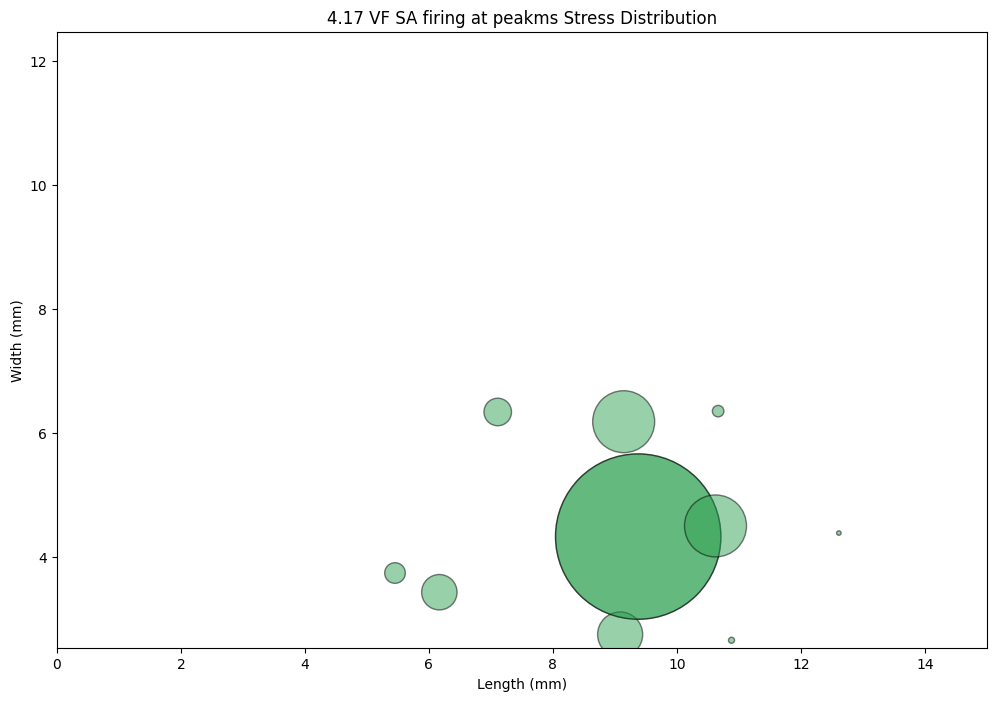

In [34]:
#Creating model class
vf_model = VF_Population_Model(4.17, "SA")
# vf_model.spatial_stress_vf_model()
vf_model.spatial_stress_vf_model(scaling_factor=1.0)
vf_model.plot_spatial_coords()


In [35]:
#Creating model class
vf_model = VF_Population_Model(4.17), "SA")
# vf_model.spatial_stress_vf_model()
vf_model.spatial_stress_vf_model(scaling_factor=3.0)
vf_model.plot_spatial_coords()


SyntaxError: unmatched ')' (1053324668.py, line 2)

RECIEVING STRESS DATA AT COORD 1 at x:9.37579and y:4.32477 MEAN STRESS IS 692.8609257967785
RECIEVING STRESS DATA AT COORD 2 at x:8.11552and y:0.891796 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 3 at x:9.07598and y:0.853945 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 4 at x:10.7199and y:1.06254 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 5 at x:12.4614and y:0.994032 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 6 at x:14.0877and y:1.17855 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 7 at x:3.19556and y:2.76538 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 8 at x:6.16837and y:3.42743 MEAN STRESS IS 88.94386140114104
RECIEVING STRESS DATA AT COORD 9 at x:9.08444and y:2.74532 MEAN STRESS IS 116.07881237799559


RECIEVING STRESS DATA AT COORD 10 at x:10.8809and y:2.65255 MEAN STRESS IS 17.422509518274623
RECIEVING STRESS DATA AT COORD 11 at x:12.6402and y:2.82572 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 12 at x:14.2156and y:2.74675 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 13 at x:3.90354and y:4.11738 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 14 at x:5.45335and y:3.73725 MEAN STRESS IS 53.68525355252208
RECIEVING STRESS DATA AT COORD 15 at x:9.37579and y:4.32477 MEAN STRESS IS 692.8609257967785
RECIEVING STRESS DATA AT COORD 16 at x:10.6228and y:4.49663 MEAN STRESS IS 151.93816581557817
RECIEVING STRESS DATA AT COORD 17 at x:12.6121and y:4.38191 MEAN STRESS IS 13.762984101969193
RECIEVING STRESS DATA AT COORD 18 at x:14.2287and y:4.55564 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 19 at x:2.65605and y:6.18535 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 20 at x:3.87949and y:6.36058 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 21 at x:5.92615and y:6.72669 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 22 at x:7.11013and y:6.33472 MEAN STRESS IS 70.94502769252864
RECIEVING STRESS DATA AT COORD 23 at x:9.1414and y:6.17783 MEAN STRESS IS 160.31357198109097
RECIEVING STRESS DATA AT COORD 24 at x:10.6651and y:6.34813 MEAN STRESS IS 31.14910438094747


RECIEVING STRESS DATA AT COORD 25 at x:12.4099and y:6.23156 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 26 at x:14.2749and y:6.12941 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 27 at x:3.88061and y:8.12861 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 28 at x:5.63259and y:7.92142 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 29 at x:7.13453and y:8.05428 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 30 at x:8.88275and y:7.89129 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 31 at x:10.7464and y:8.01549 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 32 at x:12.5447and y:7.86568 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 33 at x:14.126and y:8.0496 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 34 at x:1.98698and y:9.93782 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 35 at x:3.72471and y:9.7053 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 36 at x:5.62013and y:9.79231 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 37 at x:7.22787and y:9.59038 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 38 at x:8.95707and y:9.69289 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 39 at x:10.8726and y:9.79182 MEAN STRESS IS 0.0


RECIEVING STRESS DATA AT COORD 40 at x:12.4202and y:9.64451 MEAN STRESS IS 0.0
RECIEVING STRESS DATA AT COORD 41 at x:14.2661and y:9.82556 MEAN STRESS IS 0.0
x: 9.37579 y: 4.32477 peak_iff: 0.2
x: 6.16837 y: 3.42743 peak_iff: 0.023255813953488372
x: 9.08444 y: 2.74532 peak_iff: 0.03225806451612903
x: 10.8809 y: 2.65255 peak_iff: 0.0006901311249137336
x: 5.45335 y: 3.73725 peak_iff: 0.0125
x: 9.37579 y: 4.32477 peak_iff: 0.2
x: 10.6228 y: 4.49663 peak_iff: 0.044444444444444446
x: 12.6121 y: 4.38191 peak_iff: 0.0006213109661385523
x: 7.11013 y: 6.33472 peak_iff: 0.017094017094017096
x: 9.1414 y: 6.17783 peak_iff: 0.047619047619047616
x: 10.6651 y: 6.34813 peak_iff: 0.004273504273504274


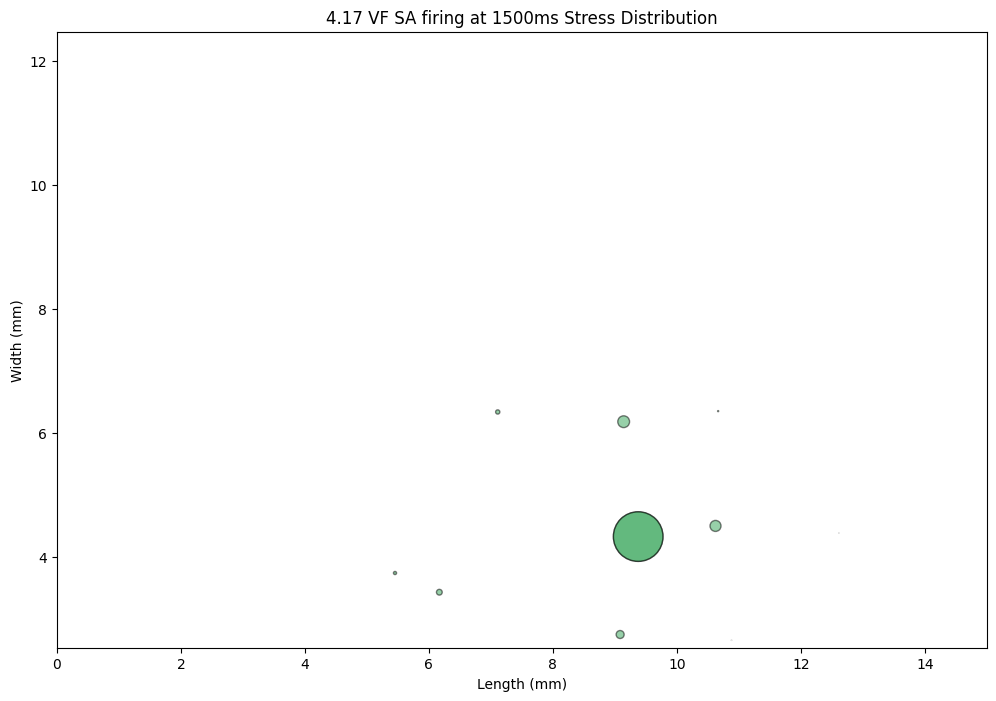

In [ ]:
#Creating model class
vf_model = VF_Population_Model(4.17, "SA")
# vf_model.spatial_stress_vf_model()
vf_model.spatial_stress_vf_model(scaling_factor= 3.0)
vf_model.plot_spatial_coords()


In [155]:
#Creating model class
vf_model = VF_Population_Model(4.56, "SA")
# vf_model.spatial_stress_vf_model()
vf_model.spatial_stress_vf_model(time_of_firing=1500)
vf_model.plot_spatial_coords()

index: 0, row: X coord (mm)    10.90120
Y coord (mm)     4.34797
Name: 0, dtype: float64


UnboundLocalError: cannot access local variable 'stress' where it is not associated with a value

**Configuring the Von-Frey Population Model**

In [ ]:
#creates model class
vf_model = VF_Population_Model(4.17, "SA")

#runs the model which calculates the results
# vf_model.spatial_stress_vf_model()
vf_model.radial_stress_vf_model()
iffs_results = vf_model.get_iffs()
stress_results = vf_model.get_stress_traces()


In [ ]:
iffs = vf_model.get_iffs()

for iff in iffs:
    print(iff)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


**Randomly Generating Afferents and setting up the configuration for the Simulation**

In [ ]:
tongue_size = (10,18)  # in mm
density_ratio = (1, 0)  # Ratio of SA and RA afferents
n_afferents = 1500
rf_sizes = {
    'SA': [1],
    'RA': [1]
}

config = SimulationConfig(tongue_size, density_ratio, n_afferents, rf_sizes,
                          stimulus_diameter=None, 
                          x_stimulus=None, y_stimulus=None,
                          stress=None)

simulation = Simulation(config)

afferents = simulation.get_afferents()


**Getting Stress & Firing Data for the Afferents**

In [ ]:
stress_data = []
iff_data = []

stresses, iffs = vf_model.simulate_afferent_response(afferents)

**Creating The Plot**

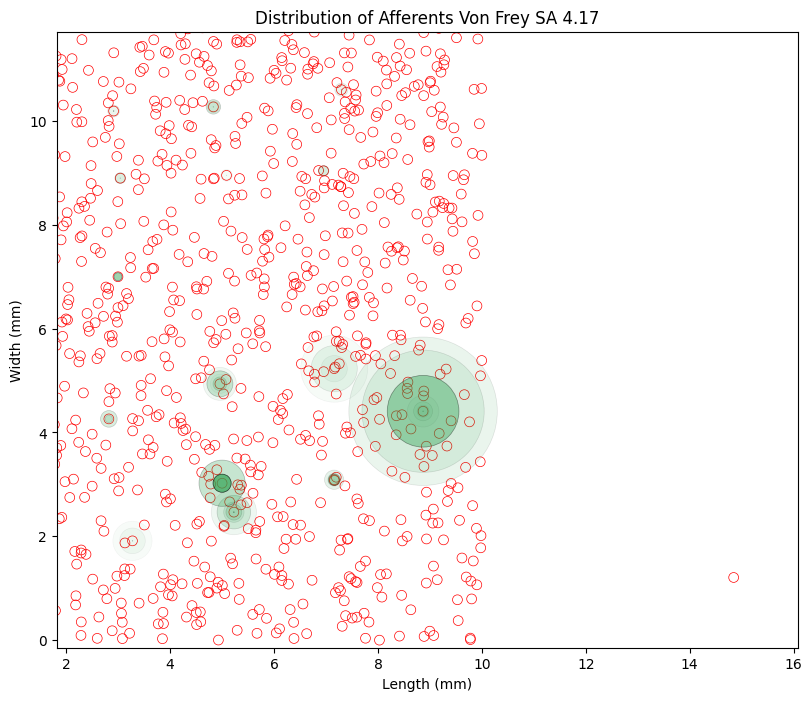

In [ ]:
vf_model.plot_afferents(iffs, afferents)

In [ ]:
stress_results.get(4).get(0.0), 
iffs_results.get(4).get(0.0)

{'afferent_type': 'SA',
 'x_position': '7.48174',
 'y_position': '1.18685',
 'num_of_spikes': 17,
 'mean_firing_frequency': 25.942516694926557,
 'peak_firing_frequency': 0.038461538461538464,
 'first_spike_time': 155.0,
 'last_spike_time': 2486.5}

In [ ]:
iffs_results.get(3)

{0.0: {'afferent_type': 'SA',
  'x_position': '5.22687',
  'y_position': '2.46636',
  'num_of_spikes': 31,
  'mean_firing_frequency': 44.738098914941304,
  'peak_firing_frequency': 0.06896551724137931,
  'first_spike_time': 129.5,
  'last_spike_time': 2487.0},
 0.33: {'afferent_type': 'SA',
  'x_position': '5.22687',
  'y_position': '2.46636',
  'num_of_spikes': 18,
  'mean_firing_frequency': 27.269562497924895,
  'peak_firing_frequency': 0.043478260869565216,
  'first_spike_time': 152.0,
  'last_spike_time': 2466.0},
 0.51: {'afferent_type': 'SA',
  'x_position': '5.22687',
  'y_position': '2.46636',
  'num_of_spikes': 13,
  'mean_firing_frequency': 21.585531606126818,
  'peak_firing_frequency': 0.03225806451612903,
  'first_spike_time': 165.5,
  'last_spike_time': 2454.0},
 0.71: {'afferent_type': 'SA',
  'x_position': '5.22687',
  'y_position': '2.46636',
  'num_of_spikes': 11,
  'mean_firing_frequency': 17.676772047343814,
  'peak_firing_frequency': 0.02666666666666667,
  'first_sp